In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [310]:
img_a = cv2.imread(r"C:\Users\Wxy\Desktop\computer-vision\experiment3\3-1.jpg")
img_b = cv2.imread(r"C:\Users\Wxy\Desktop\computer-vision\experiment3\3-2.jpg")

In [311]:
#图像a转灰度：cv2.COLOR_BGR2GRAY将BGR格式转为灰度格式
gray_a = cv2.cvtColor(img_a,cv2.COLOR_BGR2GRAY)
gray_b = cv2.cvtColor(img_b,cv2.COLOR_BGR2GRAY)

In [312]:
#初始化SIFT检测器并提取特征
sift = cv2.SIFT_create()
#提取图像a的特征：detectAndCompute()返回关键点（kp_a）和描述符（des_a），None表示不使用掩码
kp_a,des_a = sift.detectAndCompute(gray_a,None)   # 图像a的关键点（位置、尺度等）和描述符（128维向量）
kp_b,des_b = sift.detectAndCompute(gray_b,None)   #图像b的关键点和描述符

In [313]:
#使用FLANN匹配器进行特征匹配
# 使用FLANN匹配器进行特征匹配：FLANN（快速最近邻搜索库）比暴力匹配更快，适合大量特征点匹配
# 定义FLANN匹配器的算法类型：K-D树算法（适合高维数据匹配）
FLANN_INDEX_KDTREE = 1
#配置FLANN的索引参数：algorithm指定算法类型，trees=5表示构建5棵K-D树（平衡速度与精度）
index_params = dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
#配置FLANN的搜索参数：checks=50表示每个特征点最多检查50个邻居，次数越多匹配越准但速度越慢
search_params = dict(checks=50)  #检查次数越多匹配越准确但速度更慢
#创建FLANN匹配器实例：传入索引参数和搜索参数
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des_a,des_b,k=2)  #k=2表示每个特征点返回2个最佳匹配

In [314]:
#应用Low's比率测试筛选优劣匹配点
good_matches = []
for m,n in matches:
    #Lowe's比率测试：若第一匹配距离 < 0.7*第二匹配距离，判定为优质匹配（0.7是经验阈值，可在0.7-0.8调整）
    if m.distance <0.6 * n.distance:
        good_matches.append(m)

In [315]:
#绘制匹配的SIFT关键点，绘制匹配点：drawMatches()将两张图像的关键点与匹配线绘制在同一张图中
matched_keypoints_img = cv2.drawMatches(
    img_a,kp_a,img_b,kp_b,good_matches,
    None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

In [316]:
#提取匹配点的坐标
#提取图像b的匹配点坐标：m.trainIdx是b中与a匹配的特征点索引，pt是关键点的(x,y)坐标；
#转换为float32类型并reshape为(-1,1,2)（OpenCV透视变换要求的输入格式：N个点，每个点为1×2向量）
src_pts = np.float32([kp_b[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)#图像b的关键点
dst_pts = np.float32([kp_a[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)#图像a的关键点

In [317]:
#使用RANSAC算法估计单应矩阵（透视变换矩阵）
#计算单应矩阵：cv2.findHomography()输入源点、目标点，用RANSAC鲁棒算法，重投影误差阈值5.0；
#返回H（3×3单应矩阵）和mask（匹配点是否为inlier的掩码）
H,_ = cv2.findHomography(src_pts,dst_pts,cv2.RANSAC,3.0)

In [318]:
#获取输入图像的尺寸
#获取图像a的高和宽：img_a.shape[:2]返回(高度, 宽度)，因为OpenCV中图像格式为(H,W,C)
h_a, w_a = img_a.shape[:2]
h_b, w_b = img_b.shape[:2]

In [319]:
#计算图像b变换后的四个角坐标
#定义图像b的四个原始角点：按“左上(0,0)、左下(0,h_b)、右下(w_b,h_b)、右上(w_b,0)”顺序
pts = np.float32([[0,0],[0,h_b],[w_b,h_b],[w_b,0]]).reshape(-1,1,2)
#计算变换后的角点：cv2.perspectiveTransform()用单应矩阵H变换图像b的角点，得到在图像a坐标系中的位置
dst_corners = cv2.perspectiveTransform(pts,H)

In [320]:
#确定拼接后图像的最终尺寸（包含所有图像）
#合并所有角点：将图像b变换后的角点（dst_corners）与图像a的原始角点（[0,0],[w_a,0],[w_a,h_a],[0,h_a]）合并；
all_corners = np.concatenate([dst_corners,np.float32([[0,0],[w_a,0],[w_a,h_a],[0,h_a]]).reshape(-1,1,2)],axis=0)
#计算拼接图像的最小/最大坐标：all_corners.min/max(axis=0)获取所有角点的x/y最小/最大值；
#ravel()将二维数组展平，减0.5/加0.5是为了避免整数截断误差，最后转为int32类型（坐标需为整数）
[x_min,y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[x_max,y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

In [321]:
#创建平移矩阵确保所有像素都在可见区域内
#构造3×3平移矩阵：透视变换需3×3矩阵，[1,0,-x_min]表示x轴平移-x_min（抵消负坐标），[0,1,-y_min]表示y轴平移-y_min；
translation_matrix = np.array([[1,0,-x_min],[0,1,-y_min],[0,0,1]],dtype=np.float32)

In [322]:
#对图像b进行透视变换和平移
#执行透视变换：cv2.warpPerspective()根据组合矩阵变换图像b，输出尺寸为(x_max-x_min, y_max-y_min)（覆盖所有像素）
fus_img = cv2.warpPerspective(
    img_b,
    translation_matrix @ H, #组合平移矩阵和单应矩阵
    (x_max - x_min,y_max - y_min) #输出图像尺寸
)

In [323]:
#将图像a复制到拼接结果的对应位置
fus_img[-y_min:h_a - y_min,-x_min:w_a - x_min] = img_a

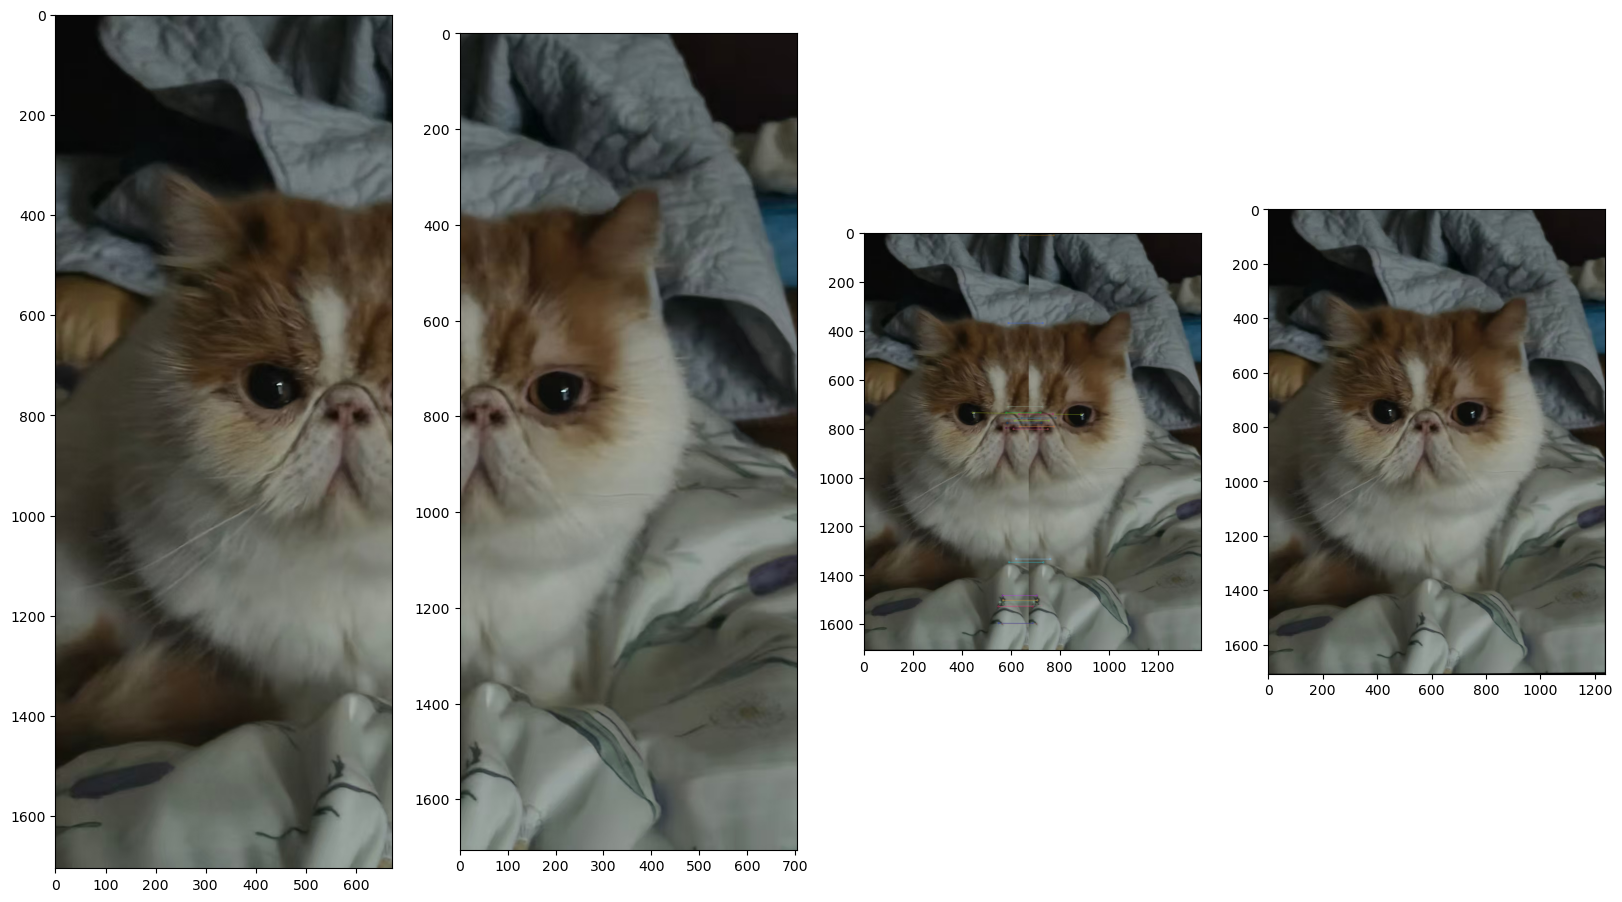

In [324]:
#显示匹配关键点和拼接结果
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(img_a,cv2.COLOR_BGR2RGB))
plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(img_b,cv2.COLOR_BGR2RGB))
plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(matched_keypoints_img,cv2.COLOR_BGR2RGB))
plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(fus_img,cv2.COLOR_BGR2RGB))